In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import torch.nn as nn
from torch import tensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data = np.load('tiny_nerf_data.npz')
images = torch.tensor(data['images'])
poses = torch.tensor(data['poses'])
focalLength = data['focal']

poses[12]
print(images.shape)
print(poses.shape)

width = images.shape[1]
height = images.shape[2]
# plt.imshow(images[10])
# for i in range(0, 100):
#     plt.imsave(f"im2/image{i}.png", images[i])
# poses[1]

torch.Size([106, 100, 100, 3])
torch.Size([106, 4, 4])


In [4]:

class NeRfModel(nn.Module):
	def __init__(self, num_fourier_features, layer_size=300):
		super().__init__()
		self.layer1 = nn.Linear(3 + 6*num_fourier_features, layer_size)
		self.layer2 = nn.Linear(layer_size, layer_size)
		self.layer3 = nn.Linear(layer_size, layer_size)
		self.layer4 = nn.Linear(layer_size, layer_size)
		self.rgb_layer = nn.Linear(layer_size, 3)
		self.radiance_layer = nn.Linear(layer_size, 1)

	def forward(self, x):
		x = nn.functional.relu(self.layer1(x))
		x = nn.functional.relu(self.layer2(x))
		x = nn.functional.relu(self.layer3(x))
		x = nn.functional.relu(self.layer4(x))

		rgb = torch.sigmoid(self.rgb_layer(x))
		radiance = self.radiance_layer(x)
		return torch.cat([rgb, radiance], dim=-1)

	# model = nn.Sequential(
	# 	# 3 for the initial x, y,z coordiante
	# 	# then for each fourier feature, one for sin(x), sin(y), sin(z), 
	# 	# and similarily 3 for cos
	# 	nn.ReLU(),
	# 	nn.Linear(300, 300),
	# 	nn.ReLU(),
	# 	nn.Linear(300, 300),
	# 	nn.ReLU(),
	# 	nn.Linear(300, 300),
	# 	nn.ReLU(),
	# 	# 3 for r, g, b and last one for radiance
	# 	nn.Linear(300, 4),
	# 	nn.Sigmoid(),
	# )

numberOfFor = 6
model  = NeRfModel(numberOfFor).to(device)

In [5]:
# %matplotlib widget

%matplotlib inline

In [6]:
# returns a two tensors, one with shape [width, height, 3] 
# representing the direction of a ray going through each pixel and another [width, height, 3] 
# representing the starting position of that same ray (all of which are the same) since 
# all rays start out at the origin
def getRays(width, height, focalLength, pose):
    xCoords = tensor([x for x in torch.arange(width)])
    yCoords = tensor([y for y in torch.arange(height)])
    x, y = torch.meshgrid(xCoords, yCoords)
    # print(x[55][49])
    # print(y[55][49])

    xShifted = (x - width*0.5)/focalLength # x coords in a [width, height] tensor
    # xShifted = nn.functional.normalize(xShifted)

    yShifted = (y - height*0.5)/focalLength # y coords in a [width, height] tensor
    # yShifted = nn.functional.normalize(yShifted)

    z = torch.ones_like(x)  # z coords in a [width, height] tensor

    # match up each element of the 3 tensors (thats why using dim = 2)
    directionVectors = torch.stack((xShifted, yShifted, z), dim=2).to(device)
    rotationMatrix = pose[0:3, 0:3]
    rotatedDirections = torch.matmul(directionVectors, rotationMatrix)

    origin =  pose[:3, 2]

    # all the rays have the same origin
    originTensor =  torch.broadcast_to(origin, rotatedDirections.shape)
    return rotatedDirections, originTensor


	# print(directionVectors.shape)
	# print(xShifted[5][0])
	# print(yShifted[5][99])
	# print(x[4][6])
	# print(y[4][6])
dirs, pos = getRays(width, height, focalLength, poses[10].to(device))
print(dirs.shape, pos.shape)
print(dirs[0][0], pos[0][0])


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([100, 100, 3]) torch.Size([100, 100, 3])
tensor([0.1192, 0.8673, 0.7020], device='cuda:0') tensor([-0.8323, -0.5092,  0.2190], device='cuda:0')


In [7]:
import matplotlib


%matplotlib inline

# matplotlib.use('WebAgg')


numberOfSamples = 25
far = 5
distanceBetweenSamples = far / numberOfSamples

def get_rays_with_samples(pose):
	dirs, pos = getRays(width, height, focalLength, pose)

	# dirs = (width, height, 3)
	# t = (numberOfSamples)
	# goal = (width, height, numberOfSamples, 3)
	# where goal[x][y][i] = dirs[x][y] * t[i]
	t = torch.linspace(0, far, numberOfSamples).reshape(1, 1, numberOfSamples, 1).to(device)

	# dirs has shape (width, height, 3) right now (a direction for every pixel)
	# We want to instead have a list of numberOfSamples for each pixel, so (width, height, numberOfSamples, 3)
	dirs = dirs.reshape(width, height, 1, 3)
	pos = pos.reshape(width, height, 1, 3)
	z = pos + t*dirs
	z = z.to(device)
	return z

# far = 2
def visulize_3D_rays(poseNumber):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection='3d')
    rays = get_rays_with_samples(poseNumber)
    with torch.no_grad():
        rays = rays.cpu()
        for i in range(0, width, 10):
            for j in range(0, height, 10):
                step = 1
                ray = rays[i][j][::step]
                ax.scatter(ray[:, 0], ray[:,1], ray[:, 2])
        ax.set_xlim3d([-far, far])
        ax.set_ylim3d([-far, far])
        ax.set_zlim3d([-far, far])
        ax.set_autoscale_on(False)

	# plt.savefig(f"img/{poseNumber}.png")
# for i in range(0, 100):
	# visulize_3D_rays(i)
# visulize_3D_rays(0)
# visulize_3D_rays(poses[5].to(device))
# print(poses[20])
# get_rays_with_samples(poses[0].to(device)).shape


In [8]:
import gc
import math
def get_model_at_each_sample_point(rays):
    #rays is (width, height, numberOfSampels, 3), we want to turn the 3 into 15 by appling foruir feature vectors
    # coord  = rays[0][0][0]
    raysBackup = torch.clone(rays)
    rays = rays.reshape(width, height, numberOfSamples, 1, 3, 1).expand(width, height, numberOfSamples, 2, 3, 1)
    twos = torch.tensor(2).repeat(width, height, numberOfSamples, 2, 3, numberOfFor) # 2 since one for sin one for cos
    # print(twos.shape)
    twos[:, :, :, :, 0] = 1
    twos = torch.cumprod(twos, dim=4).to(device)
    # print(twos)
    # Twos is a (3, numberOfFor+, 21) shaped where each row is [1, 2, 4, 8, ...]
    encoding = rays*math.pi*twos
    # print(encoding.shape)
    encoding[:, :, :, 0] = torch.sin(encoding[:, :, :, 0])
    encoding[:, :, :, 1] = torch.cos(encoding[:, :, :, 1])
    encoding = torch.flatten(encoding, start_dim=3, end_dim=5)
    # print(encoding.shape)

    # add non fourer as well (rays backup is just the normal xyz coords)
    encoding = torch.concat((raysBackup, encoding), dim=3)
    # print(encoding.shape)
    # print(encoding)

    return model(encoding)
    

def get_image(pose):
  # gc.collect()
  # torch.cuda.empty_cache()
  rays = get_rays_with_samples(pose)
  return get_image_with_rays(rays)

def get_image_with_rays(rays):
  # current (width, height, numberOfSamples, 4)
  out = get_model_at_each_sample_point(rays)
  # model_out = (width, height, numberOfSamples, 4), where r is rgb + d
  deltaI = tensor(distanceBetweenSamples)

  # Goes from out = (width,height, numberOfSamples, 4) to C = (width, height, 3)

  # The first two dimenstions are width and height
  Ti = torch.cumprod(torch.exp(-out[:, : , :, 3]*deltaI), dim = 2)
  Ti = Ti.reshape(width, height, numberOfSamples, 1)

  aboservedAmounts = (1- torch.exp(-out[:, :, :, 3]*deltaI)).reshape((width, height, numberOfSamples, 1))
  colorI = out[:, :, :, 0:3]

  # Sum along the ray (the first two dimenensions are the width and height)
  C = torch.sum(Ti*aboservedAmounts * colorI, dim = 2)
  return C

# get_image()
def f():
  with torch.no_grad():
    get_image(poses[0].to(device))
f()

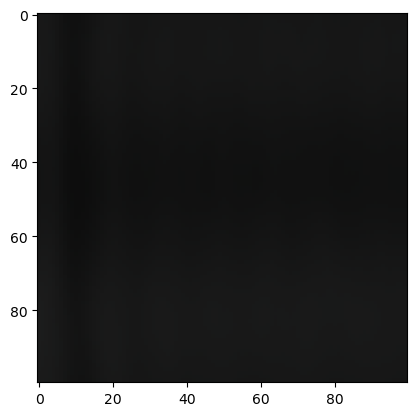

In [9]:
with torch.no_grad():
        pose = poses[0].to(device)
        im = get_image(pose).cpu()
        plt.imshow(im)

Epoch [476/10000], Loss: 0.0901965438388288:   5%|▍         | 476/10000 [08:08<2:42:44,  1.03s/it] 


KeyboardInterrupt: 

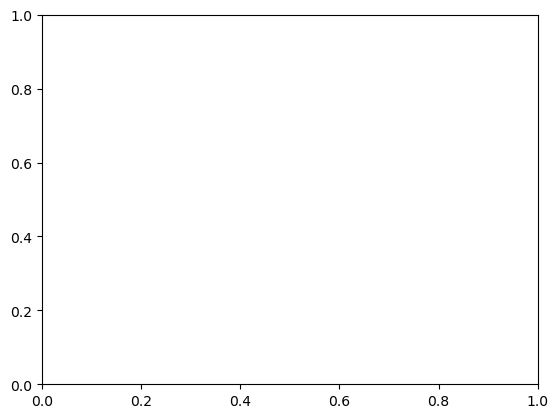

In [43]:
epochs = 10000
from tqdm import tqdm
from IPython.display import clear_output
def loss_fn(output, target):
		loss = torch.mean((output - target)**2)
		return loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(epochs))
# pbar = range(epochs)

image_display = None

fig = plt.figure()
ax = fig.gca()
i = 0
loss = 0


pose = poses[3]
# image = images[3]
# pose = pose.to(device)
# rays = get_rays_with_samples(pose)

torch.cuda.empty_cache()
poseToRays = {}
torch.cuda.empty_cache()

for epoch in pbar: 
    epoch_loss = 0
    torch.cuda.empty_cache()

    for index, (pose, image) in enumerate(zip(poses[0:10], images[0:10])):
        i += 1
        if index not in poseToRays:
              pose = pose.to(device)
              poseToRays[index] = get_rays_with_samples(pose)

        rays = poseToRays[index]
        pred_image = get_image_with_rays(rays)

        image = image.to(device)
        loss += loss_fn(pred_image, image)
        epoch_loss += loss.item()
        
        # Update the weights every 3 images
        if(i % 3 == 0):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # pbar.set_description( f"{i}: Loss is {loss}")
            loss = 0

        # if(i % 26 == 0):
        if(False):
            # print("displaying")
            with torch.no_grad():
                clear_output()
                plt.close()

                f, axarr = plt.subplots(1,2)
                axarr[0].imshow(pred_image.cpu())
                axarr[1].imshow(image.cpu())
                plt.show()

    pbar.set_description(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
    if( i >= 2000):
        i = 0
        



In [ ]:
# torch.save(model.state_dict(), "./basic_model.pkl")

In [ ]:
print(torch.max(poses[:, :, 3]))

tensor(4.0305)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


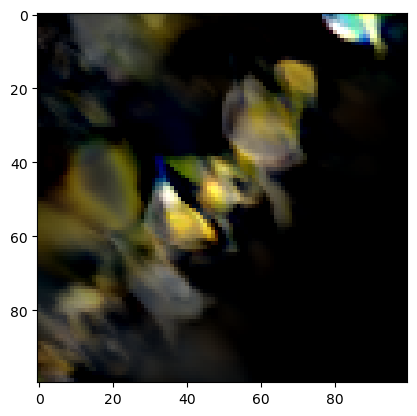

In [52]:
with torch.no_grad():
	# for i in range(0, 15):
	image  = get_image(poses[19].to(device))
	plt.imshow(image.cpu())
	plt.show()